# TRAINING UNET


In [2]:
# 1) Imports
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import random

from src.data import MontevideoFoldersDataset
from src.dl_models.unet import UNet
from src.lib.utils import print_cuda_memory
from src.train import train_model
from src.lib.utils import image_sequence_generator_folders_cosangs
from src.visualization import plot_graph_multiple

In [2]:
# 2) Set device 
USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available()
                      and USE_CUDA else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### GPU

In [3]:
print_cuda_memory()

Memory Usage:
	 Total:                  4042.375 MB.
	 Reserved (cached):      0.000 MB.
	 Allocated:              0.000 MB.


In [10]:
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cuda device: {torch.cuda.current_device()}')
print(f'Location: {torch.cuda.device(0)}')
print(f'Device count: {torch.cuda.device_count()}')
print(f'Device name: {torch.cuda.get_device_name(0)}')
# print(torch.cuda.memory_summary(abbreviated=True))

Cuda available: True
Cuda device: 0
Location: <torch.cuda.device object at 0x7f1e62e801d0>
Device count: 1
Device name: GeForce GTX 1050 Ti


In [3]:
# 3) Hyperparameters
EPOCHS = 2
BATCH_SIZE = 3 # 28 for the cluster's Tesla gpu

# 4) Load data
train_ds = MontevideoFoldersDataset(path='data/mvd/train/',    
                                    in_channel=3,
                                    out_channel=1)
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=2)

val_ds = MontevideoFoldersDataset(path='data/mvd/val/',    
                                  in_channel=3,
                                  out_channel=1)
val_loader = DataLoader(val_ds, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=2)

# 5) Initialize network
model = UNet(n_channels=3,n_classes=1,bilinear=True).to(device)

# 6) Loss and optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=0.001,betas = (0.9,0.999),
                       eps =1e-08, weight_decay=0, amsgrad=False)
criterion = nn.MSELoss()

In [6]:
print_cuda_memory()

Memory Usage:
	 Total:                  4042.375 MB.
	 Reserved (cached):      80.000 MB.
	 Allocated:              66.794 MB.


### First simple training loop, just training, no validation.

In [9]:
PRINT_EVERY = 100
TIMES = []
EPOCH_LOSS = []

for epoch in range(EPOCHS):
    for batch_idx, (in_frames, out_frames) in enumerate(train_loader):
        model.train()
        
        start = time.time()
        
        # data to cuda if possible
        in_frames = in_frames.to(device=device)
        out_frames = out_frames.to(device=device)
        
        # forward
        frames_pred = model(in_frames)
        loss = criterion(frames_pred, out_frames)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # print_cuda_memory()

        # gradient descent or adam step
        optimizer.step()
        
        end = time.time()
        TIMES.append(end - start)
        
        EPOCH_LOSS.append(loss.item())
        
        if batch_idx > 0 and batch_idx % PRINT_EVERY == 0:
            print(f'Epoch: {epoch + 1}/{EPOCHS}. Batch num: {batch_idx}/{len(train_loader)}. Train loss: {loss.item():.2f}. Time: {sum(TIMES)/len(TIMES):.2f} seg.')
            TIMES = []

Epoch: 1/1. Batch num: 100/1683. Train loss: 64.57. Time: 0.04 seg.
Epoch: 1/1. Batch num: 200/1683. Train loss: 58.62. Time: 0.05 seg.
Epoch: 1/1. Batch num: 300/1683. Train loss: 72.56. Time: 0.05 seg.
Epoch: 1/1. Batch num: 400/1683. Train loss: 137.17. Time: 0.06 seg.
Epoch: 1/1. Batch num: 500/1683. Train loss: 122.33. Time: 0.05 seg.
Epoch: 1/1. Batch num: 600/1683. Train loss: 3409.11. Time: 0.05 seg.
Epoch: 1/1. Batch num: 700/1683. Train loss: 137.83. Time: 0.06 seg.
Epoch: 1/1. Batch num: 800/1683. Train loss: 97.98. Time: 0.06 seg.
Epoch: 1/1. Batch num: 900/1683. Train loss: 250.71. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1000/1683. Train loss: 44.89. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1100/1683. Train loss: 110.79. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1200/1683. Train loss: 164.06. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1300/1683. Train loss: 646.58. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1400/1683. Train loss: 239.44. Time: 0.06 seg.
Epoch: 1/1. Batch num: 1500/1683.

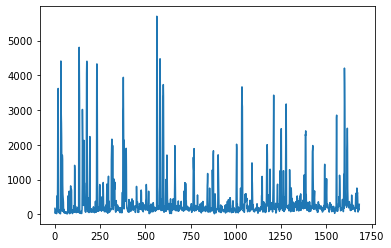

In [11]:
# Loss within the epoch:
plt.figure()
plt.plot(EPOCH_LOSS)
plt.show()

### Now i add validation

In [11]:
PRINT_EVERY = 100

TIMES = []
LOSS = []
VAL_LOSS = []
NUM_VAL_SAMPLES = 10

for epoch in range(EPOCHS):
    
    start_epoch = time.time()
    
    for batch_idx, (in_frames, out_frames) in enumerate(train_loader):
        model.train()
        
        start = time.time()
        
        # data to cuda if possible
        in_frames = in_frames.to(device=device)
        out_frames = out_frames.to(device=device)
        
        # forward
        frames_pred = model(in_frames)
        loss = criterion(frames_pred, out_frames)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # print_cuda_memory()

        # gradient descent or adam step
        optimizer.step()
        
        end = time.time()
        TIMES.append(end - start)
        
        LOSS.append(loss.item())
        
        if batch_idx > 0 and batch_idx % PRINT_EVERY == 0:
            
            # validation forward pass
            model.eval()
            
            start = time.time()
            
            with torch.no_grad():
                for val_batch_idx, (in_frames, out_frames) in enumerate(val_loader):

                    in_frames = in_frames.to(device=device)
                    out_frames = out_frames.to(device=device)

                    frames_pred = model(in_frames)
                    val_loss = criterion(frames_pred, out_frames)
                    
                    VAL_LOSS.append(val_loss.item())
                    
                    if val_batch_idx == NUM_VAL_SAMPLES:
                        break
            
            end = time.time()
            val_time = end - start
            
            # get statistics
            print(f'Epoch({epoch + 1}/{EPOCHS}) | Batch({batch_idx}/{len(train_loader)}) | ', end='')
            print(f'Train_loss({loss.item():.2f}) | Val_loss({sum(VAL_LOSS)/len(VAL_LOSS):.2f}) | ', end='')
            print(f'Time_per_batch({sum(TIMES)/len(TIMES):.2f}s) | Val_time({val_time:.2f}s)')
            TIMES = []
            VAL_LOSS = []
    
    end_epoch = time.time()
    epoch_time = end_epoch - start_epoch
    print(f'Epoch({epoch + 1}/{EPOCHS}). Time elapsed: {int(epoch_time)/60:.2f} minutes.')

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 3.95 GiB total capacity; 2.57 GiB already allocated; 40.94 MiB free; 2.64 GiB reserved in total by PyTorch)

### This next section i create a training function, teting time performance and adding features in every step

Simple training loop with just training:

In [8]:
# I need:
#   the model, the criterion, the optimizer, the loader, the num_of_epochs, print or not
#
def train_model(model, 
                criterion, 
                optimizer, 
                train_loader, 
                epochs,
                print_every=100, 
                verbose=True):

    TIME = [] # temporary list to test time performance

    for epoch in range(epochs):
        for batch_idx, (in_frames, out_frames) in enumerate(train_loader):
            model.train()
            
            start = time.time()

            # data to cuda if possible
            in_frames = in_frames.to(device=device)
            out_frames = out_frames.to(device=device)
            
            # forward
            frames_pred = model(in_frames)
            loss = criterion(frames_pred, out_frames)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            
            # gradient descent or adam step
            optimizer.step()
            
            end = time.time()
            TIME.append(end - start)   

            if verbose and batch_idx > 0 and batch_idx % print_every == 0:
                status = f'Epoch: {epoch + 1}/{EPOCHS}. Batch num: {batch_idx}/{len(train_loader)}. Train loss: {loss.item():.2f}. Time_per_batch: {sum(TIME)/len(TIME):.2f} seg.'
                print(status)

                TIME = []
            if batch_idx == 50:
                break

        

In [11]:
# This cell is for testing the functions
USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available()
                      and USE_CUDA else 'cpu')

EPOCHS = 1
BATCH_SIZE = 3 # 28 for the cluster's Tesla gpu

train_ds = MontevideoFoldersDataset(path='data/mvd/train/',    
                                    in_channel=3,
                                    out_channel=1)
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=2)

val_ds = MontevideoFoldersDataset(path='data/mvd/val/',    
                                  in_channel=3,
                                  out_channel=1)
val_loader = DataLoader(val_ds, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=2)

model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)

optimizer = optim.Adam(model.parameters(),
                       lr=0.001,betas = (0.9,0.999),
                       eps =1e-08, weight_decay=0, amsgrad=False)
criterion = nn.MSELoss()

# Test the function
train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=train_loader, 
            epochs=EPOCHS,
            print_every=10)

Epoch: 1/1. Batch num: 10/5609. Train loss: 645.59. Time_per_batch: 0.35 seg.
Epoch: 1/1. Batch num: 20/5609. Train loss: 3.36. Time_per_batch: 0.35 seg.
Epoch: 1/1. Batch num: 30/5609. Train loss: 468.13. Time_per_batch: 0.34 seg.
Epoch: 1/1. Batch num: 40/5609. Train loss: 428.40. Time_per_batch: 0.35 seg.
Epoch: 1/1. Batch num: 50/5609. Train loss: 144.17. Time_per_batch: 0.35 seg.


Just using training and no other feature, each batch takes 0.35seg to complete. If its 5609 batches, one epoch takes 32 min.

The next section i add validation

In [62]:
# I add the val_loader as input to the function, and num_val_samples
def train_model(model, 
                criterion, 
                optimizer, 
                train_loader,
                val_loader,
                epochs,
                print_every=100, 
                verbose=True,
                num_val_samples=10):

    TIME = [] # temporary list to test time performance
    VAL_LOSS = []

    for epoch in range(epochs):
        for batch_idx, (in_frames, out_frames) in enumerate(train_loader):
            model.train()
            
            start = time.time()

            # data to cuda if possible
            in_frames = in_frames.to(device=device)
            out_frames = out_frames.to(device=device)
            
            # forward
            frames_pred = model(in_frames)
            loss = criterion(frames_pred, out_frames)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            
            # gradient descent or adam step
            optimizer.step()
            
            end = time.time()

            TIME.append(end - start)   

            if verbose and batch_idx > 0 and batch_idx % print_every == 0:
                model.eval()
                
                start = time.time()
                
                with torch.no_grad():
                    for val_batch_idx, (in_frames, out_frames) in enumerate(val_loader):

                        in_frames = in_frames.to(device=device)
                        out_frames = out_frames.to(device=device)

                        frames_pred = model(in_frames)
                        val_loss = criterion(frames_pred, out_frames)
                        
                        VAL_LOSS.append(val_loss.item())
                        
                        if val_batch_idx == num_val_samples:
                            break
                
                end = time.time()
                val_time = end - start

                # get statistics
                print(f'Epoch({epoch + 1}/{EPOCHS}) | Batch({batch_idx:04d}/{len(train_loader)}) | ', end='')
                print(f'Train_loss({(loss.item()):06.2f}) | Val_loss({sum(VAL_LOSS)/len(VAL_LOSS):.2f}) | ', end='')
                print(f'Time_per_batch({sum(TIME)/len(TIME):.2f}s) | Val_time({val_time:.2f}s)')
                TIME = []

                VAL_LOSS = []
                
            if batch_idx == 50:
                break

In [65]:
# Test the function
train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            print_every=10)

Epoch(1/1) | Batch(0010/5609) | Train_loss(246.84) | Val_loss(80.26) | Time_per_batch(0.36s) | Val_time(2.20s)
Epoch(1/1) | Batch(0020/5609) | Train_loss(191.09) | Val_loss(217.51) | Time_per_batch(0.36s) | Val_time(2.19s)
Epoch(1/1) | Batch(0030/5609) | Train_loss(191.78) | Val_loss(322.47) | Time_per_batch(0.36s) | Val_time(2.21s)
Epoch(1/1) | Batch(0040/5609) | Train_loss(135.88) | Val_loss(326.60) | Time_per_batch(0.38s) | Val_time(2.71s)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc911ec6b90>
Traceback (most recent call last):
  File "/home/franco/anaconda3/envs/deepCloud/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/franco/anaconda3/envs/deepCloud/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/franco/anaconda3/envs/deepCloud/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

Time is the same, the time it takes for the validation depends on the validation size.

The next step is to save the model every x epochs

In [2]:
USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available()
                      and USE_CUDA else 'cpu')

EPOCHS = 1
BATCH_SIZE = 3 # 28 for the cluster's Tesla gpu

train_ds = MontevideoFoldersDataset(path='data/mvd/train/',    
                                    in_channel=3,
                                    out_channel=1)
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=2)

val_ds = MontevideoFoldersDataset(path='data/mvd/val/',    
                                  in_channel=3,
                                  out_channel=1)
val_loader = DataLoader(val_ds, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=2)

model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)

optimizer = optim.Adam(model.parameters(),
                       lr=0.001,betas = (0.9,0.999),
                       eps =1e-08, weight_decay=0, amsgrad=False)
criterion = nn.MSELoss()

train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            train_loader=train_loader,
            epochs=EPOCHS,
            val_loader=val_loader,
            num_val_samples=10,
            checkpoint_every=1,
            print_every=10)

Epoch(1/1) | Batch(0010/5609) | Train_loss(632.43) | Val_loss(13106.52) | 
Epoch(1/1) | Batch(0020/5609) | Train_loss(004.98) | Val_loss(236.17) | 
Epoch(1/1) | Batch(0030/5609) | Train_loss(459.07) | Val_loss(328.55) | 
Epoch(1/1) | Batch(0040/5609) | Train_loss(418.59) | Val_loss(349.07) | 
Epoch(1/1) | Batch(0050/5609) | Train_loss(139.21) | Val_loss(431.44) | 
Epoch(1/1) | Batch(0060/5609) | Train_loss(455.01) | Val_loss(343.40) | 
Epoch(1/1) | Batch(0070/5609) | Train_loss(3831.36) | Val_loss(551.57) | 
Epoch(1/1) | Batch(0080/5609) | Train_loss(4357.59) | Val_loss(650.10) | 
Epoch(1/1) | Batch(0090/5609) | Train_loss(013.40) | Val_loss(1268.59) | 
Epoch(1/1) | Batch(0100/5609) | Train_loss(275.49) | Val_loss(634.49) | 
Epoch(1/1) | Batch(0110/5609) | Train_loss(327.54) | Val_loss(814.38) | 
Epoch(1/1) | Batch(0120/5609) | Train_loss(182.63) | Val_loss(893.65) | 
Epoch(1/1) | Batch(0130/5609) | Train_loss(1813.20) | Val_loss(961.61) | 
Epoch(1/1) | Batch(0140/5609) | Train_loss(17

KeyboardInterrupt: 

In [2]:
csv_path = 'data/mvd/minidataset_mvd_train.csv'

train_mvd = MontevideoFoldersDataset(path='data/mvd/train/',    
                                     in_channel=3,
                                     out_channel=1,
                                     min_time_diff=5, max_time_diff=15,
                                     csv_path=csv_path)

train_loader = DataLoader(train_mvd, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)

for batch_idx, (in_frames, out_frames) in enumerate(train_loader):
    print(in_frames.size())
    break

torch.Size([20, 3, 256, 256])


In [16]:
# Print the unet model
from torchsummary import summary
from src.dl_models.unet import UNet

model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)


summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

### Generate the minidataset using only image days

In [2]:
PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/train'

folders = os.listdir(PATH)
random.shuffle(folders)
num_folders = len(folders)
portion = 0.1
print(num_folders)
FOLDERS = folders[0:int(num_folders * portion)]
print(len(FOLDERS))
print(FOLDERS)

CSV_PATH='/clusteruy/home03/DeepCloud/deepCloud/data/mvd/minidataset_mvd_train_cosangs.csv'
image_sequence_generator_folders_cosangs(path=PATH, in_channel=3, out_channel=1, min_time_diff=5, max_time_diff=15, csv_path=CSV_PATH, folders=FOLDERS)


229
22
['2020172', '2020076', '2020062', '2020231', '2020306', '2020021', '2020166', '2020165', '2020134', '2020294', '2020329', '2020100', '2020012', '2020027', '2020252', '2020035', '2020039', '2020198', '2020128', '2020055', '2020272', '2020308']
2020172
2020076
2020062
2020231
2020306
2020021
2020166
2020165
2020134
2020294
2020329
2020100
2020012
2020027
2020252
2020035
2020039
2020198
2020128
2020055
2020272
2020308


In [3]:
# check length
csv_path = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/minidataset_mvd_train_cosangs.csv'

# minidataset
train_mvd_minidataset = MontevideoFoldersDataset(path='data/mvd/train/',    
                                     in_channel=3,
                                     out_channel=1,
                                     min_time_diff=5, max_time_diff=15,
                                     csv_path=csv_path)
train_loader_minidataset = DataLoader(train_mvd_minidataset, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)

# regular dataset
train_mvd = MontevideoFoldersDataset(path='data/mvd/train/',    
                                     in_channel=3,
                                     out_channel=1,
                                     min_time_diff=5, max_time_diff=15)
train_loader = DataLoader(train_mvd, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)

print( len(train_loader_minidataset), len(train_loader) )

62 778


In [3]:
# create a super mini dataset to overfit
PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/train'

folders = os.listdir(PATH)
random.shuffle(folders)
num_folders = len(folders)
portion = 0.01
print(num_folders)
FOLDERS = folders[0:int(num_folders * portion)]
print(len(FOLDERS))
print(FOLDERS)

CSV_PATH='/clusteruy/home03/DeepCloud/deepCloud/data/mvd/super_minidataset_mvd_train_cosangs.csv'
image_sequence_generator_folders_cosangs(path=PATH, in_channel=3, out_channel=1, min_time_diff=5, max_time_diff=15, csv_path=CSV_PATH, folders=FOLDERS)


229
2
['2020079', '2020222']
2020079
2020222


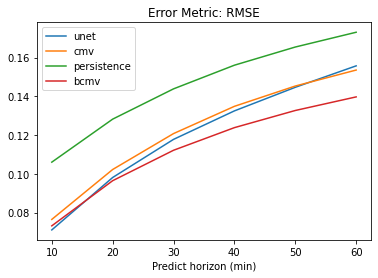

In [3]:
models_values = [[0.07103481, 0.09810332, 0.11778899, 0.13249774, 0.14467819, 0.15575126],
                 [0.07645652, 0.10223116, 0.1207803,  0.13485019, 0.14533181, 0.15358402],
                 [0.10602322, 0.12823787, 0.14387277, 0.15608841, 0.16547123, 0.17310506], 
                 [0.07314037, 0.09645177, 0.11216417, 0.12384816, 0.13270192, 0.13972196]]
models_names = ['unet', 'cmv', 'persistence', 'bcmv']
plot_graph_multiple(models_values, models_names, error_metric='RMSE', save_file='rmse_uru.png')